In [1]:
import matplotlib.pyplot as plt
import numpy as np
# ^^^ pyforest auto-imports - don't write above this line
# from pulp import *
from scipy import interpolate
from scipy.optimize import fmin, fminbound, minimize, BFGS
import math

In [2]:
class Vehicle:
    def __init__(self, ):
        self.pos=[] # x, y [m]
        self.size=[] # length, width [m]
        self.ori=[] # [rad]
        self.vel=[] # [m/s]

In [3]:
def vehicle_plot(pos, size, ori):
    if 0:
        points = [
            [pos[0] - size[0]/2, pos[0] + size[0]/2, pos[0] + size[0]/2, pos[0] - size[0]/2, pos[0] - size[0]/2],
            [pos[1] - size[1]/2, pos[1] - size[1]/2, pos[1] + size[1]/2, pos[1] + size[1]/2, pos[1] - size[1]/2]
        ]
    else:
        points = [[],[]]
        x = [- size[0]/2, size[0]/2, size[0]/2, - size[0]/2, - size[0]/2]
        y = [- size[1]/2, - size[1]/2, size[1]/2, size[1]/2, - size[1]/2]
        A = [[np.cos(ori), -np.sin(ori)],[np.sin(ori), np.cos(ori)]]
        for i in range(len(x)):
            buf = np.dot(A,np.array([x[i],y[i]]))
            points[0].append(buf[0] + pos[0])
            points[1].append(buf[1] + pos[1])
    plt.plot(points[0], points[1])

In [4]:
# 駐車車両
parked_vehicle = Vehicle()
parked_vehicle.pos = [20, 1.5]
parked_vehicle.pos = [20, .5]
parked_vehicle.size = [4, 2]
parked_vehicle.ori = 0
parked_vehicle.ori = 0

# 自社
ego_vehicle = Vehicle()
ego_vehicle.pos = [0,0]
ego_vehicle.size = [4,2]
ego_vehicle.ori = 0
ego_vehicle.vel = 10/3.6

 # 車線
width_lane = 4
line_left = [[0,40],[width_lane/2, width_lane/2]]
line_center = [[0,40], [0,0]]
line_right = [[0,40],[-width_lane/2, -width_lane/2]]

Text(0, 0.5, 'Y[m]')

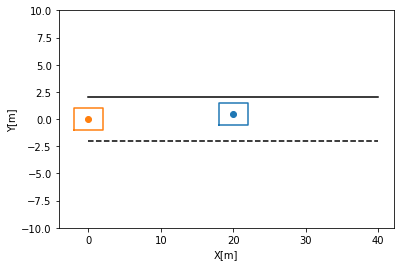

In [5]:
# 描画
plt.scatter(parked_vehicle.pos[0], parked_vehicle.pos[1])
vehicle_plot(parked_vehicle.pos, parked_vehicle.size, parked_vehicle.ori)
plt.scatter(ego_vehicle.pos[0], ego_vehicle.pos[1])
vehicle_plot(ego_vehicle.pos, ego_vehicle.size, ego_vehicle.ori)

plt.plot(line_left[0], line_left[1], 'k')
plt.plot(line_right[0], line_right[1], '--k')

plt.ylim([-10,10])
plt.xlabel('X[m]')
plt.ylabel('Y[m]')

### Ref: https://qiita.com/Ken227/items/aee6c82ec6bab92e6abf

In [6]:
#interpld
# ValueError: The number of derivatives at boundaries does not match: expected 1, got 0+0
# 2点だとエラー
def spline1(x,y,point):
    kind_option = 'cubic' if len(x) > 3 else 'quadratic'
    f = interpolate.interp1d(x, y,kind=kind_option) #kindの値は一次ならslinear、二次ならquadraticといった感じに
    X = np.linspace(x[0],x[-1],num=point,endpoint=True)
    Y = f(X)
    return X,Y

#Akima1DInterpolator
def spline2(x,y,point):
    f = interpolate.Akima1DInterpolator(x, y)
    X = np.linspace(x[0],x[-1],num=point,endpoint=True)
    Y = f(X)
    return X,Y

#splprep
def spline3(x,y,point,deg):
    tck,u = interpolate.splprep([x,y],k=deg,s=0) 
    u = np.linspace(0,1,num=point,endpoint=True) 
    spline = interpolate.splev(u,tck)
    return spline[0],spline[1]

### Ref:https://myenigma.hatenablog.com/entry/2016/10/23/043111

In [7]:
# 点列から曲率計算
def CalcCurvature(x,y,npo=1):
    cv=[]

    ndata=len(x)

    for i in range(ndata):
        lind=i-npo
        hind=i+npo+1

        if lind<0:
            lind=0
        if hind>=ndata:
            hind=ndata
        #  print(lind,hind)

        xs=x[lind:hind]
        ys=y[lind:hind]
        #  print(xs,ys)
        (cxe,cye,re)=CircleFitting(xs,ys)
        #  print(re)

        if len(xs)>=3:
            # sign evalation 
            cind=int((len(xs)-1)/2.0)
            sign = (xs[0] - xs[cind]) * (ys[-1] - ys[cind]) - (ys[0] - ys[cind]) * (xs[-1] - xs[cind])

            # check straight line
            a = np.array([xs[0]-xs[cind],ys[0]-ys[cind]])
            b = np.array([xs[-1]-xs[cind],ys[-1]-ys[cind]])
            theta=math.degrees(math.acos(np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))))
            #  print(theta)

            if theta==180.0:
                cv.append(0.0)#straight line
            elif sign>0:
                cv.append(1.0/-re)
            else:
                cv.append(1.0/re)
        else:
            cv.append(0.0)

    #  print(cv)
    return cv

# 円フィッティング
def CircleFitting(x,y):
    sumx  = sum(x)
    sumy  = sum(y)
    sumx2 = sum([ix ** 2 for ix in x])
    sumy2 = sum([iy ** 2 for iy in y])
    sumxy = sum([ix * iy for (ix,iy) in zip(x,y)])

    F = np.array([[sumx2,sumxy,sumx],
                  [sumxy,sumy2,sumy],
                  [sumx,sumy,len(x)]])

    G = np.array([[-sum([ix ** 3 + ix*iy **2 for (ix,iy) in zip(x,y)])],
                  [-sum([ix ** 2 *iy + iy **3 for (ix,iy) in zip(x,y)])],
                  [-sum([ix ** 2 + iy **2 for (ix,iy) in zip(x,y)])]])

    try:
        T=np.linalg.inv(F).dot(G)
    except:
        return (0,0,float("inf"))

    cxe=float(T[0]/-2)
    cye=float(T[1]/-2)
    #  print (cxe,cye,T)
    try:
        re=math.sqrt(cxe**2+cye**2-T[2])
    except:
        return (cxe,cye,float("inf"))
    return (cxe,cye,re)

In [8]:
# 経路評価
def evaluation_path(X):
    # X = [x1, y1, xpre]
    
    points = [
        [ego_vehicle.pos[0], parked_vehicle.pos[0] - X[2], parked_vehicle.pos[0] + X[0], line_center[0][1]], 
        [ego_vehicle.pos[1], ego_vehicle.pos[1], parked_vehicle.pos[1] + X[1], line_center[1][1]]
    ]
    
    if 0:
        path_coef = np.polyfit(points[0], points[1], 6)
        path_x= np.linspace(ego_vehicle.pos[0], line_left[0][1], 20)
        path_y = np.poly1d(path_coef)(path_x)
    else:
        path_x, path_y = spline2(points[0], points[1], 20)
        
    
    eval_val = 0 
    
    # (１)死角
    eval_val += 1 * calculation_dead_area(path_x, path_y, X[2])
    
    # (２)はみ出し
    eval_val += 1 * calculation_out_of_road(path_x, path_y)
    
    # (３)衝突
    eval_val += 1 * calculation_collision(path_x, path_y)
    
    # (４)道路中央を走行
    eval_val += 100 * calculation_center_of_road(path_x, path_y)
    
    # (５)ジャーク（yの二回微分）
    eval_val += 1 * calculation_lat_jark(path_x, path_y)    
    
    # (６)ハンドル角速度（曲率変化量） 
    eval_val += 1 * calculation_steer_vel(path_x, path_y)
    
    return eval_val

# 制約
def cons(X):
    return (X[0] + X[2])

In [9]:
# 死角の計算
def calculation_dead_area(path_x, path_y , pre):
    fr = [parked_vehicle.pos[0] + parked_vehicle.size[0]/2, parked_vehicle.pos[1] - parked_vehicle.size[1]/2]
    fl = [parked_vehicle.pos[0] + parked_vehicle.size[0]/2, parked_vehicle.pos[1] + parked_vehicle.size[1]/2]
    
    dead_area = 0
    pp = [0, 0]
    
    if 0:
        plt.scatter(parked_vehicle.pos[0], parked_vehicle.pos[1])
        vehicle_plot(parked_vehicle.pos, parked_vehicle.size, parked_vehicle.ori)
        plt.scatter(ego_vehicle.pos[0], ego_vehicle.pos[1])
        vehicle_plot(ego_vehicle.pos, ego_vehicle.size, ego_vehicle.ori)

        plt.plot(line_left[0], line_left[1], 'k')
        plt.plot(line_right[0], line_right[1], '--k')

        plt.ylim([-10,10])
        plt.xlim([0,40])
        plt.xlabel('X[m]')
        plt.ylabel('Y[m]')
    
    for i in range(len(path_x)):
        if 0:
            a = ( (fr[0] - path_x[i]) / (fr[1] - path_y[i]) ) * parked_vehicle.size[1]
            b = parked_vehicle.size[1] 
            dead_area += a * b * 1/2
        else:
            # if (path_x[i] < fr[0]) & (parked_vehicle.pos[0] - pre > path_x[i]):
            if (path_x[i] < fr[0]):
                a = (fr[1] - path_y[i]) / (fr[0] - path_x[i])
                b = fr[1] - a * fr[0]
                
                pp[0] = (fl[1] - b)/a
                pp[1] = fl[1]

                if (pp[0] > fl[0]):
                    dead_area += (pp[0] - fl[0])*(fl[1] - fr[1])*1/2
                # plt.plot([pp[0], fl[0], fr[0], pp[0]], [pp[1], fl[1], fr[1], pp[1]])
                
                if (path_y[i] > fr[1]):
                    dead_area += 1000
    
    return dead_area

In [10]:
# はみ出し
def calculation_out_of_road(path_x, path_y):
    return np.sum(path_y<line_right[1][0]) + 1000*np.sum(path_y>0)

In [11]:
# 衝突
def calculation_collision(path_x, path_y):
    d = np.sqrt((parked_vehicle.pos[0] - path_x) ** 2 + (parked_vehicle.pos[1] - path_y) ** 2)
    d_min = np.min(d)
    torelance = 3
    ret = np.sum(1/np.exp(d))
    if d_min < torelance:
        #ret = np.inf
        ret = 100000000*ret
        
    return ret

In [12]:
# 道路中央
def calculation_center_of_road(path_x, path_y):
    return np.sum(np.exp(np.abs(path_y - line_center[1][0])))

In [13]:
# 横ジャーク
def calculation_lat_jark(path_x, path_y):
    return np.sum(np.abs(np.diff(path_y, n=2)))

In [14]:
# ハンドル角速度
def calculation_steer_vel(path_x, path_y):
    cv = CalcCurvature(path_x, path_y)
    # plt.scatter(path_x, cv)
    return np.sum(np.abs(np.diff(cv, n=1)))

In [15]:
# dx, dy = fmin(evaluation_path, [0, 0])
# dx, dy = fminbound(evaluation_path, [-10, -3], [0, 0])

# X = [x1, y1, xpre]
x_init = [-5, -3, 15]

dxmin = -19
dxmax = 0
dymin = -6
dymax = 0
premin = 5
premax = 15

bounds = [[dxmin,dxmax], [dymin,dymax], [premin,premax]]
cons = (
    {'type': 'ineq', 'fun': cons}
)

res = minimize(evaluation_path, 
               x0=x_init, 
               bounds=bounds, 
               constraints=cons,
               tol = 1e-20,
               method="trust-constr",  # 制約付き信頼領域法
               jac="2-point",          # 勾配関数
               hess=BFGS(),            # ヘシアンの推定方法
               options={"maxiter": 1000, # 最大反復数
                         "verbose":2} # 最適化の過程を出力
              )  
            

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   4   |   0   | +2.1543e+04 | 1.00e+00 | 1.31e+10 | 0.00e+00 |
|   2   |   8   |   1   | +2.1543e+04 | 5.00e-01 | 1.31e+10 | 0.00e+00 |
|   3   |  12   |   2   | +2.1543e+04 | 2.50e-01 | 1.31e+10 | 0.00e+00 |
|   4   |  16   |   3   | +2.0774e+04 | 2.50e-01 | 1.27e+10 | 3.46e-02 |
|   5   |  20   |   4   | +2.0699e+04 | 2.50e-01 | 1.31e+10 | 4.73e-02 |
|   6   |  24   |   5   | +2.0699e+04 | 1.25e-01 | 1.31e+10 | 4.73e-02 |
|   7   |  28   |   6   | +2.0699e+04 | 6.25e-02 | 1.31e+10 | 4.73e-02 |
|   8   |  32   |   7   | +2.0658e+04 | 6.25e-02 | 2.01e+10 | 5.09e-02 |
|   9   |  36   |  10   | +2.0501e+04 | 6.25e-02 | 2.02e+10 | 7.88e-02 |
|  10   |  40   |  11   | +2.0501e+04 | 3.12e-02 | 2.02e+10 | 7.88e-02 |
|  11   |  44   |  12   | +2.0273e+04 | 3.12e-02 | 2.03e+10 | 7.85e-02 |
|  12   |  48   |  14   | +2.0052e+04 | 3.12e-02 | 

/usr/local/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


|  18   |  72   |  22   | +2.0050e+04 | 1.95e-03 | 1.14e+04 | 7.91e-02 |
|  19   |  76   |  24   | +2.0050e+04 | 1.09e-02 | 1.14e+04 | 7.92e-02 |
|  20   |  80   |  26   | +2.0049e+04 | 6.13e-02 | 2.04e+10 | 7.96e-02 |
|  21   |  84   |  29   | +2.0049e+04 | 3.06e-02 | 2.04e+10 | 7.96e-02 |
|  22   |  88   |  32   | +2.0018e+04 | 3.06e-02 | 2.04e+10 | 9.35e-02 |
|  23   |  92   |  35   | +1.9987e+04 | 3.06e-02 | 1.31e+10 | 1.07e-01 |
|  24   |  96   |  38   | +1.9987e+04 | 1.53e-02 | 1.31e+10 | 1.07e-01 |
|  25   |  100  |  41   | +1.9987e+04 | 7.66e-03 | 1.31e+10 | 1.07e-01 |
|  26   |  104  |  44   | +1.9987e+04 | 3.83e-03 | 1.31e+10 | 1.07e-01 |
|  27   |  108  |  46   | +1.9987e+04 | 1.91e-03 | 1.31e+10 | 1.07e-01 |
|  28   |  112  |  48   | +1.9987e+04 | 9.57e-04 | 1.31e+10 | 1.07e-01 |
|  29   |  116  |  49   | +1.9986e+04 | 9.57e-04 | 1.13e+04 | 1.07e-01 |
|  30   |  120  |  52   | +1.9986e+04 | 9.57e-05 | 1.13e+04 | 1.07e-01 |
|  31   |  124  |  55   | +1.9986e+04 | 6.70e-04 | 

|  131  |  384  |  244  | +2.1249e+04 | 1.00e-08 | 1.81e+10 | 0.00e+00 |
|  132  |  388  |  247  | +2.1249e+04 | 1.00e-09 | 1.81e+10 | 0.00e+00 |
|  133  |  392  |  249  | +2.1249e+04 | 1.00e-09 | 1.81e+10 | 0.00e+00 |
|  134  |  396  |  252  | +2.1249e+04 | 1.00e-10 | 1.81e+10 | 0.00e+00 |
|  135  |  400  |  254  | +2.1249e+04 | 1.00e-10 | 1.81e+10 | 0.00e+00 |
|  136  |  404  |  256  | +2.1249e+04 | 1.00e-11 | 1.81e+10 | 0.00e+00 |
|  137  |  412  |  258  | +2.1249e+04 | 1.00e-12 | 1.81e+10 | 0.00e+00 |
|  138  |  416  |  260  | +2.1249e+04 | 1.00e-12 | 1.81e+10 | 0.00e+00 |
|  139  |  424  |  262  | +2.1249e+04 | 1.00e-13 | 1.81e+10 | 0.00e+00 |
|  140  |  428  |  264  | +2.1249e+04 | 1.00e-13 | 1.13e+04 | 0.00e+00 |
|  141  |  428  |  266  | +2.1249e+04 | 1.00e-14 | 1.13e+04 | 0.00e+00 |
|  142  |  428  |  268  | +2.1249e+04 | 3.11e-15 | 1.13e+04 | 0.00e+00 |
|  143  |  428  |  270  | +2.1249e+04 | 1.56e-15 | 1.13e+04 | 0.00e+00 |
|  144  |  428  |  272  | +2.1249e+04 | 1.09e-14 | 

|  250  |  428  |  532  | +2.1249e+04 | 9.77e-20 | 1.13e+04 | 0.00e+00 |
|  251  |  428  |  534  | +2.1249e+04 | 4.88e-20 | 1.13e+04 | 0.00e+00 |
|  252  |  428  |  536  | +2.1249e+04 | 2.44e-20 | 1.13e+04 | 0.00e+00 |
|  253  |  428  |  538  | +2.1249e+04 | 1.22e-20 | 1.13e+04 | 0.00e+00 |
|  254  |  428  |  540  | +2.1249e+04 | 6.10e-21 | 1.13e+04 | 0.00e+00 |
|  255  |  428  |  540  | +2.1249e+04 | 1.00e+00 | 1.13e+04 | 0.00e+00 |
|  256  |  428  |  543  | +2.1249e+04 | 1.00e-01 | 1.13e+04 | 0.00e+00 |
|  257  |  428  |  546  | +2.1249e+04 | 1.00e-02 | 1.13e+04 | 0.00e+00 |
|  258  |  428  |  549  | +2.1249e+04 | 1.00e-03 | 1.13e+04 | 0.00e+00 |
|  259  |  428  |  552  | +2.1249e+04 | 1.00e-04 | 1.13e+04 | 0.00e+00 |
|  260  |  428  |  555  | +2.1249e+04 | 1.00e-05 | 1.13e+04 | 0.00e+00 |
|  261  |  428  |  558  | +2.1249e+04 | 1.00e-06 | 1.13e+04 | 0.00e+00 |
|  262  |  428  |  561  | +2.1249e+04 | 1.00e-07 | 1.13e+04 | 0.00e+00 |
|  263  |  428  |  564  | +2.1249e+04 | 1.00e-08 | 

|  377  |  428  |  846  | +2.1249e+04 | 1.22e-20 | 1.13e+04 | 0.00e+00 |
|  378  |  428  |  848  | +2.1249e+04 | 6.10e-21 | 1.13e+04 | 0.00e+00 |
|  379  |  428  |  848  | +2.1249e+04 | 1.00e+00 | 1.13e+04 | 0.00e+00 |
|  380  |  428  |  851  | +2.1249e+04 | 1.00e-01 | 1.13e+04 | 0.00e+00 |
|  381  |  428  |  854  | +2.1249e+04 | 1.00e-02 | 1.13e+04 | 0.00e+00 |
|  382  |  428  |  857  | +2.1249e+04 | 1.00e-03 | 1.13e+04 | 0.00e+00 |
|  383  |  428  |  860  | +2.1249e+04 | 1.00e-04 | 1.13e+04 | 0.00e+00 |
|  384  |  428  |  863  | +2.1249e+04 | 1.00e-05 | 1.13e+04 | 0.00e+00 |
|  385  |  428  |  866  | +2.1249e+04 | 1.00e-06 | 1.13e+04 | 0.00e+00 |
|  386  |  428  |  869  | +2.1249e+04 | 1.00e-07 | 1.13e+04 | 0.00e+00 |
|  387  |  428  |  872  | +2.1249e+04 | 1.00e-08 | 1.13e+04 | 0.00e+00 |
|  388  |  428  |  875  | +2.1249e+04 | 1.00e-09 | 1.13e+04 | 0.00e+00 |
|  389  |  428  |  878  | +2.1249e+04 | 1.00e-10 | 1.13e+04 | 0.00e+00 |
|  390  |  428  |  881  | +2.1249e+04 | 1.00e-11 | 

|  504  |  428  | 1159  | +2.1249e+04 | 1.00e-01 | 1.13e+04 | 0.00e+00 |
|  505  |  428  | 1162  | +2.1249e+04 | 1.00e-02 | 1.13e+04 | 0.00e+00 |
|  506  |  428  | 1165  | +2.1249e+04 | 1.00e-03 | 1.13e+04 | 0.00e+00 |
|  507  |  428  | 1168  | +2.1249e+04 | 1.00e-04 | 1.13e+04 | 0.00e+00 |
|  508  |  428  | 1171  | +2.1249e+04 | 1.00e-05 | 1.13e+04 | 0.00e+00 |
|  509  |  428  | 1174  | +2.1249e+04 | 1.00e-06 | 1.13e+04 | 0.00e+00 |
|  510  |  428  | 1177  | +2.1249e+04 | 1.00e-07 | 1.13e+04 | 0.00e+00 |
|  511  |  428  | 1180  | +2.1249e+04 | 1.00e-08 | 1.13e+04 | 0.00e+00 |
|  512  |  428  | 1183  | +2.1249e+04 | 1.00e-09 | 1.13e+04 | 0.00e+00 |
|  513  |  428  | 1186  | +2.1249e+04 | 1.00e-10 | 1.13e+04 | 0.00e+00 |
|  514  |  428  | 1189  | +2.1249e+04 | 1.00e-11 | 1.13e+04 | 0.00e+00 |
|  515  |  428  | 1192  | +2.1249e+04 | 1.00e-12 | 1.13e+04 | 0.00e+00 |
|  516  |  428  | 1195  | +2.1249e+04 | 1.00e-13 | 1.13e+04 | 0.00e+00 |
|  517  |  428  | 1198  | +2.1249e+04 | 1.00e-14 | 

|  629  |  428  | 1470  | +2.1249e+04 | 1.00e-02 | 1.13e+04 | 0.00e+00 |
|  630  |  428  | 1473  | +2.1249e+04 | 1.00e-03 | 1.13e+04 | 0.00e+00 |
|  631  |  428  | 1476  | +2.1249e+04 | 1.00e-04 | 1.13e+04 | 0.00e+00 |
|  632  |  428  | 1479  | +2.1249e+04 | 1.00e-05 | 1.13e+04 | 0.00e+00 |
|  633  |  428  | 1482  | +2.1249e+04 | 1.00e-06 | 1.13e+04 | 0.00e+00 |
|  634  |  428  | 1485  | +2.1249e+04 | 1.00e-07 | 1.13e+04 | 0.00e+00 |
|  635  |  428  | 1488  | +2.1249e+04 | 1.00e-08 | 1.13e+04 | 0.00e+00 |
|  636  |  428  | 1491  | +2.1249e+04 | 1.00e-09 | 1.13e+04 | 0.00e+00 |
|  637  |  428  | 1494  | +2.1249e+04 | 1.00e-10 | 1.13e+04 | 0.00e+00 |
|  638  |  428  | 1497  | +2.1249e+04 | 1.00e-11 | 1.13e+04 | 0.00e+00 |
|  639  |  428  | 1500  | +2.1249e+04 | 1.00e-12 | 1.13e+04 | 0.00e+00 |
|  640  |  428  | 1503  | +2.1249e+04 | 1.00e-13 | 1.13e+04 | 0.00e+00 |
|  641  |  428  | 1506  | +2.1249e+04 | 1.00e-14 | 1.13e+04 | 0.00e+00 |
|  642  |  428  | 1509  | +2.1249e+04 | 1.00e-15 | 

|  759  |  428  | 1796  | +2.1249e+04 | 1.00e-08 | 1.13e+04 | 0.00e+00 |
|  760  |  428  | 1799  | +2.1249e+04 | 1.00e-09 | 1.13e+04 | 0.00e+00 |
|  761  |  428  | 1802  | +2.1249e+04 | 1.00e-10 | 1.13e+04 | 0.00e+00 |
|  762  |  428  | 1805  | +2.1249e+04 | 1.00e-11 | 1.13e+04 | 0.00e+00 |
|  763  |  428  | 1808  | +2.1249e+04 | 1.00e-12 | 1.13e+04 | 0.00e+00 |
|  764  |  428  | 1811  | +2.1249e+04 | 1.00e-13 | 1.13e+04 | 0.00e+00 |
|  765  |  428  | 1814  | +2.1249e+04 | 1.00e-14 | 1.13e+04 | 0.00e+00 |
|  766  |  428  | 1817  | +2.1249e+04 | 1.00e-15 | 1.13e+04 | 0.00e+00 |
|  767  |  428  | 1820  | +2.1249e+04 | 1.00e-16 | 1.13e+04 | 0.00e+00 |
|  768  |  428  | 1823  | +2.1249e+04 | 5.00e-17 | 1.13e+04 | 0.00e+00 |
|  769  |  428  | 1825  | +2.1249e+04 | 2.50e-17 | 1.13e+04 | 0.00e+00 |
|  770  |  428  | 1827  | +2.1249e+04 | 1.25e-17 | 1.13e+04 | 0.00e+00 |
|  771  |  428  | 1829  | +2.1249e+04 | 6.25e-18 | 1.13e+04 | 0.00e+00 |
|  772  |  428  | 1831  | +2.1249e+04 | 3.13e-18 | 

|  891  |  428  | 2128  | +2.1249e+04 | 1.00e-16 | 1.13e+04 | 0.00e+00 |
|  892  |  428  | 2131  | +2.1249e+04 | 5.00e-17 | 1.13e+04 | 0.00e+00 |
|  893  |  428  | 2133  | +2.1249e+04 | 2.50e-17 | 1.13e+04 | 0.00e+00 |
|  894  |  428  | 2135  | +2.1249e+04 | 1.25e-17 | 1.13e+04 | 0.00e+00 |
|  895  |  428  | 2137  | +2.1249e+04 | 6.25e-18 | 1.13e+04 | 0.00e+00 |
|  896  |  428  | 2139  | +2.1249e+04 | 3.13e-18 | 1.13e+04 | 0.00e+00 |
|  897  |  428  | 2141  | +2.1249e+04 | 1.56e-18 | 1.13e+04 | 0.00e+00 |
|  898  |  428  | 2143  | +2.1249e+04 | 7.81e-19 | 1.13e+04 | 0.00e+00 |
|  899  |  428  | 2145  | +2.1249e+04 | 3.91e-19 | 1.13e+04 | 0.00e+00 |
|  900  |  428  | 2147  | +2.1249e+04 | 1.95e-19 | 1.13e+04 | 0.00e+00 |
|  901  |  428  | 2149  | +2.1249e+04 | 9.77e-20 | 1.13e+04 | 0.00e+00 |
|  902  |  428  | 2151  | +2.1249e+04 | 4.88e-20 | 1.13e+04 | 0.00e+00 |
|  903  |  428  | 2153  | +2.1249e+04 | 2.44e-20 | 1.13e+04 | 0.00e+00 |
|  904  |  428  | 2155  | +2.1249e+04 | 1.22e-20 | 

In [16]:
res

 barrier_parameter: 2.6843545600000044e-21
 barrier_tolerance: 2.6843545600000044e-21
          cg_niter: 2311
      cg_stop_cond: 2
            constr: [array([9.7245687]), array([-5.00713535, -3.03926286, 14.73170405])]
       constr_nfev: [428, 0]
       constr_nhev: [0, 0]
       constr_njev: [0, 0]
    constr_penalty: 1.0
  constr_violation: 0.0
    execution_time: 8.255122900009155
               fun: 21248.841328228402
              grad: array([ -1208.07867715, -13843.87874546,   -692.56725516])
               jac: [array([[ 1.00000001, -0.        ,  1.        ]]), array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])]
   lagrangian_grad: array([ -1144.02520586, -11325.75143144,    -45.62820992])
           message: '`xtol` termination condition is satisfied.'
            method: 'tr_interior_point'
              nfev: 428
              nhev: 0
               nit: 967
             niter: 967
              njev: 0
        optimality: 11325.751431440105
            stat

In [17]:
dx, dy, pre = res.x
dx, dy, pre

(-5.007135348501046, -3.039262855689115, 14.731704047131654)

Text(0, 0.5, 'Y[m]')

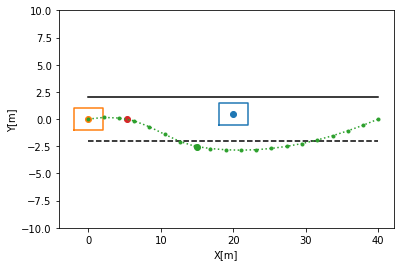

In [18]:
points = [
    [ego_vehicle.pos[0], parked_vehicle.pos[0] - pre, parked_vehicle.pos[0] + dx, line_center[0][1]], 
    [ego_vehicle.pos[1], ego_vehicle.pos[1], parked_vehicle.pos[1] + dy, line_center[1][1]]
]

if 0:
    path_coef = np.polyfit(points[0], points[1], 6)
    path_x= np.linspace(ego_vehicle.pos[0], line_left[0][1], 20)
    path_y = np.poly1d(path_coef)(path_x)
else:
    path_x, path_y = spline2(points[0], points[1], 20)

plt.scatter(parked_vehicle.pos[0], parked_vehicle.pos[1])
vehicle_plot(parked_vehicle.pos, parked_vehicle.size, parked_vehicle.ori)
plt.scatter(ego_vehicle.pos[0], ego_vehicle.pos[1])
vehicle_plot(ego_vehicle.pos, ego_vehicle.size, ego_vehicle.ori)

plt.plot(line_left[0], line_left[1], 'k')
plt.plot(line_right[0], line_right[1], '--k')

plt.scatter(points[0][2], points[1][2])
plt.scatter(points[0][1], points[1][1])
plt.plot(path_x, path_y,':.')

plt.ylim([-10,10])
plt.xlabel('X[m]')
plt.ylabel('Y[m]')

In [19]:
calculation_dead_area(path_x, path_y,pre)

4182.364342901973

In [20]:
calculation_collision(path_x, path_y)

0.08687165851280604

In [21]:
calculation_center_of_road(path_x, path_y)

150.55045054472237

In [22]:
calculation_out_of_road(path_x, path_y)

2009

In [23]:
calculation_lat_jark(path_x, path_y)

2.109031829930228

In [24]:
calculation_steer_vel(path_x, path_y)

0.23602736575095323

In [25]:
dx, dy, pre = -5, -3, 15

Text(0, 0.5, 'Y[m]')

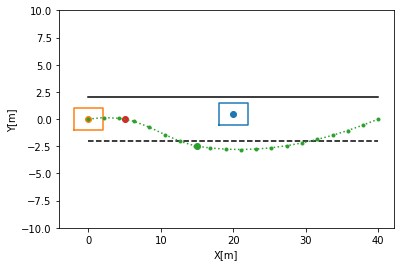

In [26]:
points = [
    [ego_vehicle.pos[0], parked_vehicle.pos[0] - pre, parked_vehicle.pos[0] + dx, line_center[0][1]], 
    [ego_vehicle.pos[1], ego_vehicle.pos[1], parked_vehicle.pos[1] + dy, line_center[1][1]]
]

if 0:
    path_coef = np.polyfit(points[0], points[1], 6)
    path_x= np.linspace(ego_vehicle.pos[0], line_left[0][1], 20)
    path_y = np.poly1d(path_coef)(path_x)
else:
    path_x, path_y = spline2(points[0], points[1], 20)

plt.scatter(parked_vehicle.pos[0], parked_vehicle.pos[1])
vehicle_plot(parked_vehicle.pos, parked_vehicle.size, parked_vehicle.ori)
plt.scatter(ego_vehicle.pos[0], ego_vehicle.pos[1])
vehicle_plot(ego_vehicle.pos, ego_vehicle.size, ego_vehicle.ori)

plt.plot(line_left[0], line_left[1], 'k')
plt.plot(line_right[0], line_right[1], '--k')

plt.scatter(points[0][2], points[1][2])
plt.scatter(points[0][1], points[1][1])
plt.plot(path_x, path_y,':.')

plt.ylim([-10,10])
plt.xlabel('X[m]')
plt.ylabel('Y[m]')

In [27]:
calculation_dead_area(path_x, path_y,pre)

4160.67070666885

In [28]:
calculation_collision(path_x, path_y)

0.09126943890032943

In [29]:
calculation_center_of_road(path_x, path_y)

143.71351877129464

In [30]:
calculation_out_of_road(path_x, path_y)

3009

In [31]:
calculation_lat_jark(path_x, path_y)

2.0301569713758094

In [32]:
calculation_steer_vel(path_x, path_y)

0.21795674572413942